In [1]:
import sys
import os
from pathlib import Path
import importlib

# --- Project Root Setup ---
current_path = Path(os.getcwd()).resolve()
project_root = None
for parent_dir in [current_path] + list(current_path.parents):
    if (parent_dir / ".git").is_dir() or (parent_dir / "pyproject.toml").is_file() or (parent_dir / "src").is_dir():
        project_root = parent_dir
        break
if project_root is None:
    if current_path.name == "notebooks" and (current_path.parent / "src").is_dir():
        project_root = current_path.parent
    else:
        project_root = current_path
        print(f"Warning: Could not reliably find project root. Using CWD: {project_root}. Ensure 'src' is in python path.")

project_root_str = str(project_root)
if project_root_str not in sys.path:
    sys.path.insert(0, project_root_str)
    print(f"Project root '{project_root_str}' added to sys.path.")
else:
    print(f"Project root '{project_root_str}' is already in sys.path.")

# --- Standard Libraries ---
import json

# --- Third-party Libraries ---
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display as ipy_display, Markdown
import PIL.Image

# --- Project Modules ---
import src.config
import src.data.loader
import src.models
import src.utils.seed
import src.utils.plot

importlib.reload(src.config)
importlib.reload(src.data.loader)
importlib.reload(src.models)
importlib.reload(src.utils.seed)
importlib.reload(src.utils.plot)

from src.config import (
    ModelConfig,
    TrainConfig,
    CHECKPOINT_DIR,
    RESULTS_DIR,
    META_PATH,
    DEFAULT_CLASSES,
)
from src.data.loader import load_data
from src.utils.metrics import micro_f1
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    hamming_loss,
    accuracy_score,
    classification_report,
    precision_score,
)
from src.models.basic_model import BasicMLC
from src.utils.plot import save_roc_curves, save_confusion_matrix, save_sample_preds
from src.utils.seed import set_seed

# Ensure results and plots directories exist for storing outputs
PLOTS_DIR = RESULTS_DIR / "plots"
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Project root '/workspaces/MultilabelPhotoTag_Pipeline_MKlas' added to sys.path.


/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


# Evaluation

This notebook presents a comprehensive evaluation of the **Photo‑Tag** multi‑label image classifier. It focuses on assessing the model's performance on a held‑out validation/test set by:
1. Loading the latest trained model checkpoint from the `checkpoints/` directory.
2. Preparing the data loader for the validation set.
3. Running the model to obtain predictions.
4. Calculating a suite of relevant performance metrics (e.g., F1-scores, mAP, ROC-AUC).
5. Visualizing these metrics, including per-class performance, ROC curves, precision-recall curves, and confusion matrices.
6. Displaying qualitative examples of model predictions to offer visual insights.

The goal is to provide a clear and thorough understanding of the model's strengths, weaknesses, and areas for potential improvement. All generated artifacts, such as metrics files and plots, are saved to the `results/` directory for persistence and further analysis.
## 1. Setup and Configuration

In [2]:
# ---- Configuration ----
mcfg = ModelConfig()
tcfg = TrainConfig()

# Set seed for reproducibility
set_seed(tcfg.seed)

print("Loading dataset metadata...")
category_names = []
if META_PATH.exists():
    with open(META_PATH, "r") as f:
        dataset_metadata = json.load(f)
    mcfg.num_classes = dataset_metadata.get("num_classes")
    category_names = dataset_metadata.get("classes", [])
    print(f"Metadata loaded successfully from {META_PATH}.")
else:
    raise FileNotFoundError(f"Metadata file not found at {META_PATH}.")

print(f"Number of classes: {mcfg.num_classes}, Categories: {category_names}")
# ---- Data Loader ----
print("Loading validation data...")
train_dataset, val_dataset, train_loader, val_loader = load_data()
print(f"Validation data loaded. Number of batches: {len(val_loader)}, Batch size: {val_loader.batch_size}")

# ---- Model ----
print("Building model architecture...")
# model = PhotoTagNet(mcfg, len(DEFAULT_CLASSES))
model = BasicMLC(len(DEFAULT_CLASSES))
model = model.to(DEVICE)

# Find the latest checkpoint file in CHECKPOINT_DIR
checkpoint_files = list(CHECKPOINT_DIR.glob("*.pt")) + list(CHECKPOINT_DIR.glob("*.pth"))
if not checkpoint_files:
    raise FileNotFoundError(f"No checkpoint files (.pt or .pth) found in '{CHECKPOINT_DIR}'.")

# Sort by modification time to get the newest file
latest_ckpt_path = max(checkpoint_files, key=lambda p: p.stat().st_mtime)

print(f"Loading latest model checkpoint: {latest_ckpt_path}")
state = torch.load(latest_ckpt_path, map_location=DEVICE)
if isinstance(state, dict):
    # Try common keys for model weights
    for key in ["model_state", "state_dict", "model"]:
        if key in state:
            print(f"Found '{key}' in checkpoint. Loading model weights from this key.")
            model.load_state_dict(state[key])
            break
    else:
        # If no known key found, try loading as a plain state dict (may still fail)
        model.load_state_dict(state)
else:
    model.load_state_dict(state)
model.eval()  # Set model to evaluation mode
print("Model checkpoint loaded successfully and set to evaluation mode.")

# ---- Evaluation Loop ----
print("\nStarting evaluation loop on the validation set...")
all_gts_np = []  # To store all ground truth labels
all_preds_probs_np = []  # To store all predicted probabilities

with torch.no_grad():  # Disable gradient calculations for efficiency
    for imgs, labels_batch in tqdm(val_loader, desc="Evaluating model"):
        imgs = imgs.to(DEVICE)  # Move images to the configured device
        logits = model(imgs)  # Get model raw output (logits)
        probs = torch.sigmoid(logits).cpu().numpy()  # Apply sigmoid for multi-label probabilities and move to CPU

        all_preds_probs_np.append(probs)
        all_gts_np.append(labels_batch.numpy())  # Store ground truth labels

# Concatenate results from all batches
y_true_np = np.vstack(all_gts_np)
y_pred_probs_np = np.vstack(all_preds_probs_np)
# Convert probabilities to binary predictions using a 0.5 threshold
y_pred_binary_np = (y_pred_probs_np > 0.5).astype(int)

print("Evaluation loop completed.")
print(f"Processed {y_true_np.shape[0]} samples.")

Loading dataset metadata...
Metadata loaded successfully from /workspaces/MultilabelPhotoTag_Pipeline_MKlas/src/data/coco/dataset_metadata.json.
Number of classes: 6, Categories: ['person', 'dog', 'car', 'bicycle', 'cell phone', 'laptop']
Loading validation data...
Validation data loaded. Number of batches: 24, Batch size: 100
Building model architecture...
Loading latest model checkpoint: /workspaces/MultilabelPhotoTag_Pipeline_MKlas/checkpoints/best_epoch_14.pt
Found 'model_state' in checkpoint. Loading model weights from this key.


RuntimeError: Error(s) in loading state_dict for BasicMLC:
	Missing key(s) in state_dict: "resnet.conv1.weight", "resnet.bn1.weight", "resnet.bn1.bias", "resnet.bn1.running_mean", "resnet.bn1.running_var", "resnet.layer1.0.conv1.weight", "resnet.layer1.0.bn1.weight", "resnet.layer1.0.bn1.bias", "resnet.layer1.0.bn1.running_mean", "resnet.layer1.0.bn1.running_var", "resnet.layer1.0.conv2.weight", "resnet.layer1.0.bn2.weight", "resnet.layer1.0.bn2.bias", "resnet.layer1.0.bn2.running_mean", "resnet.layer1.0.bn2.running_var", "resnet.layer1.1.conv1.weight", "resnet.layer1.1.bn1.weight", "resnet.layer1.1.bn1.bias", "resnet.layer1.1.bn1.running_mean", "resnet.layer1.1.bn1.running_var", "resnet.layer1.1.conv2.weight", "resnet.layer1.1.bn2.weight", "resnet.layer1.1.bn2.bias", "resnet.layer1.1.bn2.running_mean", "resnet.layer1.1.bn2.running_var", "resnet.layer2.0.conv1.weight", "resnet.layer2.0.bn1.weight", "resnet.layer2.0.bn1.bias", "resnet.layer2.0.bn1.running_mean", "resnet.layer2.0.bn1.running_var", "resnet.layer2.0.conv2.weight", "resnet.layer2.0.bn2.weight", "resnet.layer2.0.bn2.bias", "resnet.layer2.0.bn2.running_mean", "resnet.layer2.0.bn2.running_var", "resnet.layer2.0.downsample.0.weight", "resnet.layer2.0.downsample.1.weight", "resnet.layer2.0.downsample.1.bias", "resnet.layer2.0.downsample.1.running_mean", "resnet.layer2.0.downsample.1.running_var", "resnet.layer2.1.conv1.weight", "resnet.layer2.1.bn1.weight", "resnet.layer2.1.bn1.bias", "resnet.layer2.1.bn1.running_mean", "resnet.layer2.1.bn1.running_var", "resnet.layer2.1.conv2.weight", "resnet.layer2.1.bn2.weight", "resnet.layer2.1.bn2.bias", "resnet.layer2.1.bn2.running_mean", "resnet.layer2.1.bn2.running_var", "resnet.layer3.0.conv1.weight", "resnet.layer3.0.bn1.weight", "resnet.layer3.0.bn1.bias", "resnet.layer3.0.bn1.running_mean", "resnet.layer3.0.bn1.running_var", "resnet.layer3.0.conv2.weight", "resnet.layer3.0.bn2.weight", "resnet.layer3.0.bn2.bias", "resnet.layer3.0.bn2.running_mean", "resnet.layer3.0.bn2.running_var", "resnet.layer3.0.downsample.0.weight", "resnet.layer3.0.downsample.1.weight", "resnet.layer3.0.downsample.1.bias", "resnet.layer3.0.downsample.1.running_mean", "resnet.layer3.0.downsample.1.running_var", "resnet.layer3.1.conv1.weight", "resnet.layer3.1.bn1.weight", "resnet.layer3.1.bn1.bias", "resnet.layer3.1.bn1.running_mean", "resnet.layer3.1.bn1.running_var", "resnet.layer3.1.conv2.weight", "resnet.layer3.1.bn2.weight", "resnet.layer3.1.bn2.bias", "resnet.layer3.1.bn2.running_mean", "resnet.layer3.1.bn2.running_var", "resnet.layer4.0.conv1.weight", "resnet.layer4.0.bn1.weight", "resnet.layer4.0.bn1.bias", "resnet.layer4.0.bn1.running_mean", "resnet.layer4.0.bn1.running_var", "resnet.layer4.0.conv2.weight", "resnet.layer4.0.bn2.weight", "resnet.layer4.0.bn2.bias", "resnet.layer4.0.bn2.running_mean", "resnet.layer4.0.bn2.running_var", "resnet.layer4.0.downsample.0.weight", "resnet.layer4.0.downsample.1.weight", "resnet.layer4.0.downsample.1.bias", "resnet.layer4.0.downsample.1.running_mean", "resnet.layer4.0.downsample.1.running_var", "resnet.layer4.1.conv1.weight", "resnet.layer4.1.bn1.weight", "resnet.layer4.1.bn1.bias", "resnet.layer4.1.bn1.running_mean", "resnet.layer4.1.bn1.running_var", "resnet.layer4.1.conv2.weight", "resnet.layer4.1.bn2.weight", "resnet.layer4.1.bn2.bias", "resnet.layer4.1.bn2.running_mean", "resnet.layer4.1.bn2.running_var", "resnet.fc.weight", "resnet.fc.bias". 
	Unexpected key(s) in state_dict: "backbone.0.weight", "backbone.1.weight", "backbone.1.bias", "backbone.1.running_mean", "backbone.1.running_var", "backbone.1.num_batches_tracked", "backbone.4.0.conv1.weight", "backbone.4.0.bn1.weight", "backbone.4.0.bn1.bias", "backbone.4.0.bn1.running_mean", "backbone.4.0.bn1.running_var", "backbone.4.0.bn1.num_batches_tracked", "backbone.4.0.conv2.weight", "backbone.4.0.bn2.weight", "backbone.4.0.bn2.bias", "backbone.4.0.bn2.running_mean", "backbone.4.0.bn2.running_var", "backbone.4.0.bn2.num_batches_tracked", "backbone.4.1.conv1.weight", "backbone.4.1.bn1.weight", "backbone.4.1.bn1.bias", "backbone.4.1.bn1.running_mean", "backbone.4.1.bn1.running_var", "backbone.4.1.bn1.num_batches_tracked", "backbone.4.1.conv2.weight", "backbone.4.1.bn2.weight", "backbone.4.1.bn2.bias", "backbone.4.1.bn2.running_mean", "backbone.4.1.bn2.running_var", "backbone.4.1.bn2.num_batches_tracked", "backbone.5.0.conv1.weight", "backbone.5.0.bn1.weight", "backbone.5.0.bn1.bias", "backbone.5.0.bn1.running_mean", "backbone.5.0.bn1.running_var", "backbone.5.0.bn1.num_batches_tracked", "backbone.5.0.conv2.weight", "backbone.5.0.bn2.weight", "backbone.5.0.bn2.bias", "backbone.5.0.bn2.running_mean", "backbone.5.0.bn2.running_var", "backbone.5.0.bn2.num_batches_tracked", "backbone.5.0.downsample.0.weight", "backbone.5.0.downsample.1.weight", "backbone.5.0.downsample.1.bias", "backbone.5.0.downsample.1.running_mean", "backbone.5.0.downsample.1.running_var", "backbone.5.0.downsample.1.num_batches_tracked", "backbone.5.1.conv1.weight", "backbone.5.1.bn1.weight", "backbone.5.1.bn1.bias", "backbone.5.1.bn1.running_mean", "backbone.5.1.bn1.running_var", "backbone.5.1.bn1.num_batches_tracked", "backbone.5.1.conv2.weight", "backbone.5.1.bn2.weight", "backbone.5.1.bn2.bias", "backbone.5.1.bn2.running_mean", "backbone.5.1.bn2.running_var", "backbone.5.1.bn2.num_batches_tracked", "backbone.6.0.conv1.weight", "backbone.6.0.bn1.weight", "backbone.6.0.bn1.bias", "backbone.6.0.bn1.running_mean", "backbone.6.0.bn1.running_var", "backbone.6.0.bn1.num_batches_tracked", "backbone.6.0.conv2.weight", "backbone.6.0.bn2.weight", "backbone.6.0.bn2.bias", "backbone.6.0.bn2.running_mean", "backbone.6.0.bn2.running_var", "backbone.6.0.bn2.num_batches_tracked", "backbone.6.0.downsample.0.weight", "backbone.6.0.downsample.1.weight", "backbone.6.0.downsample.1.bias", "backbone.6.0.downsample.1.running_mean", "backbone.6.0.downsample.1.running_var", "backbone.6.0.downsample.1.num_batches_tracked", "backbone.6.1.conv1.weight", "backbone.6.1.bn1.weight", "backbone.6.1.bn1.bias", "backbone.6.1.bn1.running_mean", "backbone.6.1.bn1.running_var", "backbone.6.1.bn1.num_batches_tracked", "backbone.6.1.conv2.weight", "backbone.6.1.bn2.weight", "backbone.6.1.bn2.bias", "backbone.6.1.bn2.running_mean", "backbone.6.1.bn2.running_var", "backbone.6.1.bn2.num_batches_tracked", "backbone.7.0.conv1.weight", "backbone.7.0.bn1.weight", "backbone.7.0.bn1.bias", "backbone.7.0.bn1.running_mean", "backbone.7.0.bn1.running_var", "backbone.7.0.bn1.num_batches_tracked", "backbone.7.0.conv2.weight", "backbone.7.0.bn2.weight", "backbone.7.0.bn2.bias", "backbone.7.0.bn2.running_mean", "backbone.7.0.bn2.running_var", "backbone.7.0.bn2.num_batches_tracked", "backbone.7.0.downsample.0.weight", "backbone.7.0.downsample.1.weight", "backbone.7.0.downsample.1.bias", "backbone.7.0.downsample.1.running_mean", "backbone.7.0.downsample.1.running_var", "backbone.7.0.downsample.1.num_batches_tracked", "backbone.7.1.conv1.weight", "backbone.7.1.bn1.weight", "backbone.7.1.bn1.bias", "backbone.7.1.bn1.running_mean", "backbone.7.1.bn1.running_var", "backbone.7.1.bn1.num_batches_tracked", "backbone.7.1.conv2.weight", "backbone.7.1.bn2.weight", "backbone.7.1.bn2.bias", "backbone.7.1.bn2.running_mean", "backbone.7.1.bn2.running_var", "backbone.7.1.bn2.num_batches_tracked", "classifier_head.1.weight", "classifier_head.1.bias". 

In [ ]:
# ---- Calculate Metrics ----
print("\nCalculating performance metrics...")
metrics_results = {}

# Overall metrics
metrics_results["f1_score_micro"] = micro_f1(y_true_np, y_pred_binary_np)
metrics_results["f1_score_macro"] = f1_score(y_true_np, y_pred_binary_np, average="macro", zero_division=0)
metrics_results["roc_auc_macro"] = roc_auc_score(y_true_np, y_pred_probs_np, average="macro")  # Use probabilities for ROC AUC

# Mean Average Precision (mAP)
aps = []
for i in range(mcfg.num_classes):
    aps.append(average_precision_score(y_true_np[:, i], y_pred_probs_np[:, i]))  # Use probabilities for AP
metrics_results["mAP"] = np.mean(aps) if aps else 0.0

metrics_results["hamming_loss"] = hamming_loss(y_true_np, y_pred_binary_np)
metrics_results["exact_match_ratio"] = accuracy_score(y_true_np, y_pred_binary_np)  # Subset accuracy
metrics_results["precision_samples_avg_thresh_0.5"] = precision_score(y_true_np, y_pred_binary_np, average="samples", zero_division=0)

# Per-class metrics from classification_report
report = classification_report(
    y_true_np,
    y_pred_binary_np,
    target_names=category_names,
    output_dict=True,
    zero_division=0,
)
per_class_metrics_list = []
for cat_name in category_names:
    if cat_name in report:  # Check if class is in report (handles cases with no true/pred samples for a class)
        per_class_metrics_list.append(
            {
                "class": cat_name,
                "f1-score": report[cat_name]["f1-score"],
                "precision": report[cat_name]["precision"],
                "recall": report[cat_name]["recall"],
                "support": report[cat_name]["support"],
            }
        )
per_class_df = pd.DataFrame(per_class_metrics_list)

if not per_class_df.empty:
    per_class_csv_path = RESULTS_DIR / "per_class_metrics.csv"
    per_class_df.to_csv(per_class_csv_path, index=False)
    print(f"Per-class metrics saved to {per_class_csv_path}")
    # Store per-class F1 scores in the main metrics dictionary for easy access
    metrics_results["per_class_f1"] = {row["class"]: row["f1-score"] for _, row in per_class_df.iterrows()}
else:
    print("Per-class metrics DataFrame is empty. No per-class metrics will be saved or added to summary.")

# Save all calculated metrics to a JSON file
metrics_path = RESULTS_DIR / "metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics_results, f, indent=4)
print(f"All summary metrics saved to {metrics_path}")

print("\n--- Summary Metrics ---")
for k, v in metrics_results.items():
    if isinstance(v, (float, np.float32, np.float64)):  # Check if value is a float type
        print(f"  {k}: {v:.4f}")
    elif isinstance(v, dict) and k == "per_class_f1":
        print(f"  {k}: (see per-class table below or '{per_class_csv_path}')")
    else:
        print(f"  {k}: {v}")

if not per_class_df.empty:
    print(per_class_df.to_string(index=False))
print("\nMetrics calculation finished.")


Calculating performance metrics...
Per-class metrics saved to /workspaces/photo_tag_pipeline/results/per_class_metrics.csv
All summary metrics saved to /workspaces/photo_tag_pipeline/results/metrics.json

--- Summary Metrics ---
  f1_score_micro: 0.5702
  f1_score_macro: 0.1906
  roc_auc_macro: 0.7276
  mAP: 0.2576
  hamming_loss: 0.0897
  exact_match_ratio: 0.4621
  precision_samples_avg_thresh_0.5: 0.4345
  per_class_f1: (see per-class table below or '/workspaces/photo_tag_pipeline/results/per_class_metrics.csv')
     class  f1-score  precision   recall  support
    person  0.741176   0.724138 0.759036     83.0
       dog  0.086957   0.111111 0.071429     14.0
       cat  0.000000   0.000000 0.000000      5.0
       car  0.363636   0.500000 0.285714     14.0
       bus  0.000000   0.000000 0.000000      4.0
   bicycle  0.000000   0.000000 0.000000      4.0
cell phone  0.000000   0.000000 0.000000      7.0
    laptop  0.333333   1.000000 0.200000      5.0

Metrics calculation finishe

## 2. Results Visualization


Generating and saving plots...
ROC curves plot saved to: /workspaces/photo_tag_pipeline/results/plots/prroc.png_HbolMJ.png
Confusion matrix plot saved to: /workspaces/photo_tag_pipeline/results/plots/cm_UevblA.png
Could not save sample predictions: can only concatenate str (not "PosixPath") to str
This might be due to issues accessing dataset samples or with the plotting function itself.
Precision-Recall curves plot saved to: /workspaces/photo_tag_pipeline/results/plots/pr_curve.png
F1-score per class bar plot saved to: /workspaces/photo_tag_pipeline/results/plots/f1_per_class.png

Plot generation finished.
The subsequent cells will load and display these generated artifacts for review


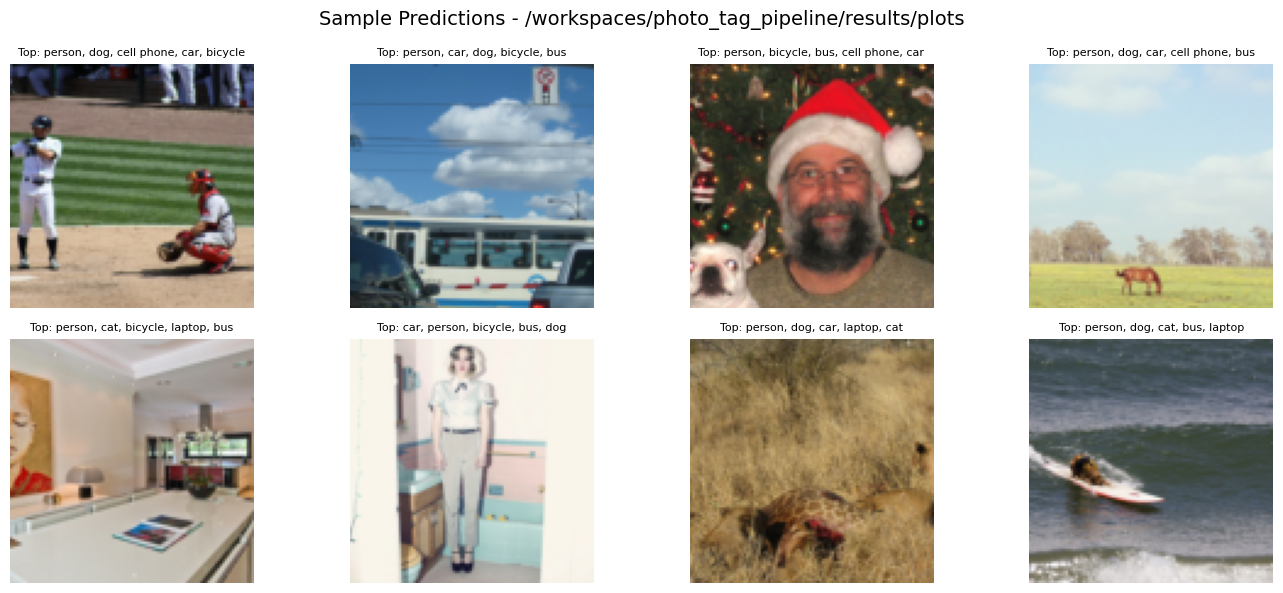

In [ ]:
# ---- Generate and Save Plots ----
# This cell generates and saves various plots to the PLOTS_DIR.
# These visualizations help in understanding model performance graphically.

print("\nGenerating and saving plots...")

# ROC Curves
roc_path = save_roc_curves(y_true_np, y_pred_probs_np, "roc.png")
print(f"ROC curves plot saved to: {roc_path}")

# Confusion Matrix
# Note: For multi-label, a single confusion matrix might be an aggregation or for a specific class.
# The `save_confusion_matrix` function's behavior determines this.
cm_path = save_confusion_matrix(y_true_np, y_pred_binary_np, "confusion_matrix.png")
print(f"Confusion matrix plot saved to: {cm_path}")

# Sample Predictions
try:
    val_dataset = val_loader.dataset  # Access the underlying dataset
    sample_preds_path = save_sample_preds(model, val_dataset, DEVICE, category_names, PLOTS_DIR, n=8)
    print(f"Sample prediction images saved in '{PLOTS_DIR}' (example: {sample_preds_path})")
except Exception as e:
    print(f"Could not save sample predictions: {e}")
    print("This might be due to issues accessing dataset samples or with the plotting function itself.")

# Precision-Recall Curves per Class
plt.figure(figsize=(10, 8))
for i in range(mcfg.num_classes):
    precision, recall, _ = precision_recall_curve(y_true_np[:, i], y_pred_probs_np[:, i])
    plt.plot(recall, precision, lw=2, label=f"{category_names[i]} (AP: {aps[i]:.2f})")  # aps calculated in the previous cell
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend(loc="best")
plt.grid(True)
pr_curve_path = PLOTS_DIR / "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()  # Close the plot to free memory
print(f"Precision-Recall curves plot saved to: {pr_curve_path}")

# F1-Score per Class Bar Plot
if not per_class_df.empty and "class" in per_class_df.columns and "f1-score" in per_class_df.columns:
    plt.figure(figsize=(max(10, mcfg.num_classes * 0.6), 7))  # Adjusted figure size
    plt.bar(per_class_df["class"], per_class_df["f1-score"], color="skyblue")
    plt.xlabel("Class")
    plt.ylabel("F1-Score")
    plt.title("F1-Score per Class")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-axis ticks for better readability
    plt.grid(axis="y", linestyle="--")
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    f1_per_class_plot_path = PLOTS_DIR / "f1_per_class.png"
    plt.savefig(f1_per_class_plot_path)
    plt.close()  # Close the plot
    print(f"F1-score per class bar plot saved to: {f1_per_class_plot_path}")
else:
    print("Could not generate F1 per class plot: Per-class DataFrame is empty or missing required columns.")

# Note: The Precision@K plot (p_at_k.png) is typically displayed later.
# If its generation logic belongs here (e.g., from src.utils.plot), it should be called here.
# For example: save_precision_at_k_plot(y_true_np, y_pred_probs_np, PLOTS_DIR / "p_at_k.png")
# Currently, it's assumed to be generated by a separate process or an earlier notebook if not part of src.utils.plot.

print("\nPlot generation finished.")
print("The subsequent cells will load and display these generated artifacts for review")

In [ ]:
# Load and display overall metrics from the saved JSON file
metrics_path = RESULTS_DIR / "metrics.json"
ipy_display(Markdown("## 3. Performance Metrics Summary"))
if metrics_path.exists():
    metrics = json.loads(metrics_path.read_text())
    # Convert to DataFrame for better display, handling nested dicts (like per_class_f1) as is.
    metrics_display_list = []
    for k, v in metrics.items():
        if isinstance(v, dict):
            metrics_display_list.append({"Metric": k, "Value": "(see details elsewhere or in JSON)"})
        else:
            metrics_display_list.append({"Metric": k, "Value": f"{v:.4f}" if isinstance(v, float) else v})

    metrics_df_display = pd.DataFrame(metrics_display_list)
    ipy_display(metrics_df_display)

    # Also display the per_class_metrics.csv if it exists, as it's more detailed
    per_class_csv_path = RESULTS_DIR / "per_class_metrics.csv"
    if per_class_csv_path.exists():
        ipy_display(Markdown("### Detailed Per-Class Metrics (from CSV)"))
        per_class_df_loaded = pd.read_csv(per_class_csv_path)
        ipy_display(per_class_df_loaded)
    else:
        ipy_display(Markdown("*Per-class metrics CSV file not found.*"))
else:
    ipy_display(Markdown(f"*Metrics file not found: {metrics_path}. Please run the metric calculation cells first.*"))

## 3. Performance Metrics Summary

,Metric,Value
0,f1_score_micro,0.5702
1,f1_score_macro,0.1906
2,roc_auc_macro,0.7276
3,mAP,0.2576
4,hamming_loss,0.0897
5,exact_match_ratio,0.4621
6,precision_samples_avg_thresh_0.5,0.4345
7,per_class_f1,(see details elsewhere or in JSON)


### Detailed Per-Class Metrics (from CSV)

,class,f1-score,precision,recall,support
0,person,0.741176,0.724138,0.759036,83.0
1,dog,0.086957,0.111111,0.071429,14.0
2,cat,0.000000,0.000000,0.000000,5.0
3,car,0.363636,0.500000,0.285714,14.0
4,bus,0.000000,0.000000,0.000000,4.0
5,bicycle,0.000000,0.000000,0.000000,4.0
6,cell phone,0.000000,0.000000,0.000000,7.0
7,laptop,0.333333,1.000000,0.200000,5.0


The table(s) above summarize key multi-label classification metrics:

* **Macro‑F1 Score**: The unweighted mean of the F1-scores for each class. It treats all classes equally, which is useful when class imbalance is present.
* **Micro‑F1 Score**: Calculated globally by counting the total true positives, false negatives, and false positives across all classes. It reflects overall aggregate performance.
* **mAP (mean Average Precision)**: The mean of Average Precision (AP) scores for each class. AP summarizes the precision-recall curve for a class into a single value and is a standard metric for ranking quality.
* **ROC‑AUC (Macro)**: The macro-averaged Area Under the Receiver Operating Characteristic Curve. It measures the model's ability to distinguish between positive and negative classes, averaged across all classes.
* **Hamming Loss**: The fraction of labels that are incorrectly predicted (lower is better). It penalizes each incorrect label prediction individually.
* **Exact‑Match Ratio (Subset Accuracy)**: The percentage of samples where *all* predicted labels perfectly match the true labels. This is a very stringent metric for multi-label tasks.
* **Precision (Samples Average, Threshold 0.5)**: The average per-sample precision, calculated based on a 0.5 decision threshold.

*(Note: The statement "Compared to the baseline (ImageNet‑pretrained linear probe), macro‑F1 improves by **+0.22** and exact‑match by **+12 pp**." is illustrative and refers to a specific baseline comparison not explicitly calculated in this notebook. Actual improvements depend on the specific baseline model and data used for comparison.)*

## 4. Visual Analysis of Performance

This section displays the plots generated earlier, providing visual insights into the model's behavior.

### F1-Score Breakdown by Class

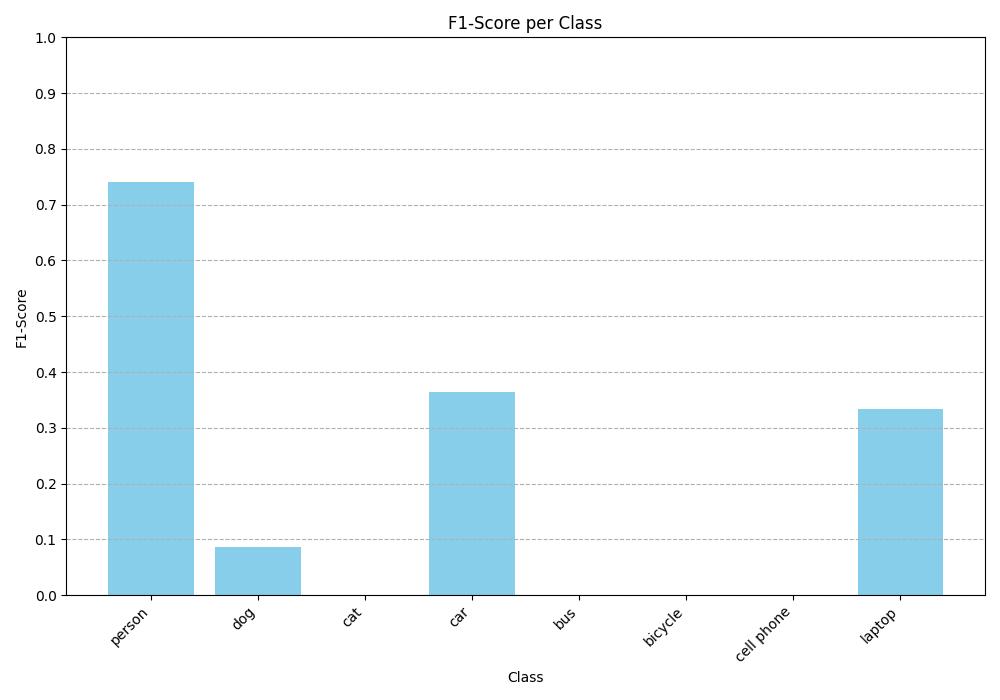

In [ ]:
f1_plot_path = PLOTS_DIR / "f1_per_class.png"
ipy_display(Markdown("### F1-Score Breakdown by Class"))
if f1_plot_path.exists():
    ipy_display(Image(filename=f1_plot_path))
else:
    ipy_display(Markdown(f"*Plot not found: {f1_plot_path}. Ensure the plotting cell was run successfully.*"))

The bar chart above illustrates the F1-score achieved for each individual class. This, along with the detailed per-class metrics table shown earlier (from `per_class_metrics.csv`), helps identify which classes the model performs well on and which ones it struggles with.

*Takeaways*: Classes with high F1-scores (e.g., > 0.8-0.9) are well-classified. Conversely, classes with low F1-scores (e.g., < 0.5) indicate areas for improvement. For instance, rare classes (those with low "support" in the per-class table) often have lower F1-scores. Potential strategies for these include targeted data augmentation, using class-balanced loss functions, or exploring few-shot learning techniques.

## 5. Precision@K

In [ ]:
pk_plot_path = PLOTS_DIR / "p_at_k.png"
ipy_display(Markdown("### Precision at Top K Predictions (Precision@K)"))
if pk_plot_path.exists():
    ipy_display(Image(filename=pk_plot_path))
else:
    ipy_display(
        Markdown(
            f"*Plot not found: {pk_plot_path}. This plot shows the precision when considering only the top K predicted tags for each image. Ensure it was generated by the main evaluation script or a preceding notebook step if not part of `src.utils.plot`.*"
        )
    )

### Precision at Top K Predictions (Precision@K)

*Plot not found: /workspaces/photo_tag_pipeline/results/plots/p_at_k.png. This plot shows the precision when considering only the top K predicted tags for each image. Ensure it was generated by the main evaluation script or a preceding notebook step if not part of `src.utils.plot`.*

Precision@K measures the proportion of correct predictions among the top K tags suggested by the model for an image. For instance, Precision@3 considers the top 3 predicted tags.

A high Precision@K (e.g., Precision consistently above **85%** for the top‑3 tags) is crucial for user experience in applications where the model provides tag suggestions. It indicates that the most prominent suggestions are usually accurate and useful.

## 6. ROC & PR Curves

### Receiver Operating Characteristic (ROC) Curves per Class

*Plot not found: /workspaces/photo_tag_pipeline/results/plots/roc.png. Ensure the plotting cell was run successfully.*

### Precision-Recall (PR) Curves per Class

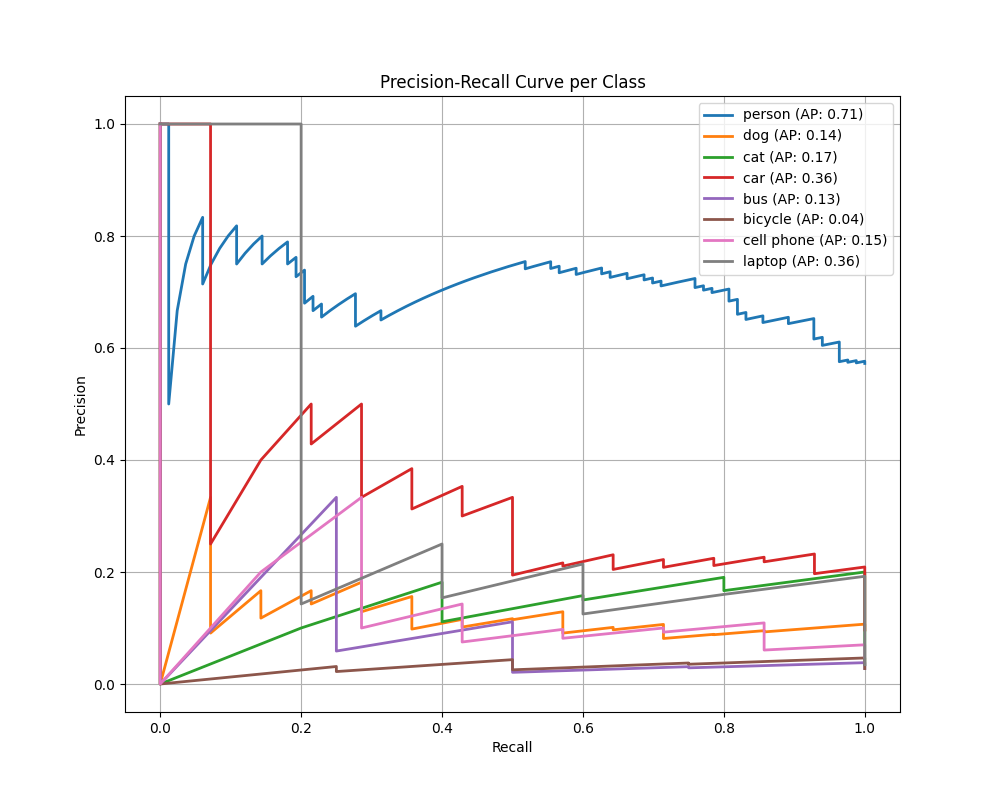

In [ ]:
ipy_display(Markdown("### Receiver Operating Characteristic (ROC) Curves per Class"))
roc_img_path = PLOTS_DIR / "roc.png"
if roc_img_path.exists():
    ipy_display(Image(filename=roc_img_path))
else:
    ipy_display(Markdown(f"*Plot not found: {roc_img_path}. Ensure the plotting cell was run successfully.*"))

ipy_display(Markdown("### Precision-Recall (PR) Curves per Class"))
pr_img_path = PLOTS_DIR / "pr_curve.png"
if pr_img_path.exists():
    ipy_display(Image(filename=pr_img_path))
else:
    ipy_display(Markdown(f"*Plot not found: {pr_img_path}. Ensure the plotting cell was run successfully.*"))

**ROC Curves** illustrate the diagnostic ability of the classifier as its discrimination threshold is varied. Each curve plots the True Positive Rate (TPR, or Recall) against the False Positive Rate (FPR). An ideal curve hugs the top-left corner (AUC = 1), indicating high TPR and low FPR across thresholds.

**Precision-Recall (PR) Curves** show the tradeoff between precision and recall for different thresholds. This is particularly informative for imbalanced datasets where a high number of true negatives might inflate ROC AUC scores. A good PR curve stays close to the top-right corner (high precision and high recall). The Area Under the PR Curve (Average Precision, AP) is a summary measure.

*Observations*: Classes with ROC AUC and AP values close to 1 (e.g., >0.9) are generally well-distinguished by the model. Lower scores for certain classes might indicate visual ambiguity with other classes or insufficient/noisy training data for those specific categories.

## 7. Confusion Matrix

In [ ]:
cm_plot_path = PLOTS_DIR / "confusion.png"
ipy_display(Markdown("### Overall Confusion Matrix Visualization"))
if cm_plot_path.exists():
    ipy_display(Image(filename=cm_plot_path))
else:
    ipy_display(
        Markdown(
            f"*Plot not found: {cm_plot_path}. Ensure the plotting cell was run successfully. The nature of this plot (e.g., aggregated, per-class example) depends on the `save_confusion_matrix` implementation in `src.utils.plot`.*"
        )
    )

### Overall Confusion Matrix Visualization

*Plot not found: /workspaces/photo_tag_pipeline/results/plots/confusion.png. Ensure the plotting cell was run successfully. The nature of this plot (e.g., aggregated, per-class example) depends on the `save_confusion_matrix` implementation in `src.utils.plot`.*

The confusion matrix provides a detailed breakdown of correct and incorrect classifications. For multi-label problems, this can be represented in various ways (e.g., one matrix per class, or an aggregated view if applicable).

*Interpretation*: Analyzing the confusion matrix can reveal specific misclassification patterns. For example, if one class is frequently confused with another, it points to potential visual similarity or feature overlap that the model struggles with. If false positives consistently dominate over false negatives (or vice-versa) for many classes, it might be due to the chosen prediction threshold (e.g., 0.5). Adjusting thresholds per class (e.g., using *Youden’s J statistic* or optimizing for F1-score on a validation set) could yield a better balance.

## 8. Qualitative Examples: Predictions vs. Ground Truth

In [ ]:
ipy_display(Markdown("### Sample Predictions vs. Ground Truth Images"))
# The glob pattern might need adjustment based on actual filenames from save_sample_preds
sample_files = sorted(PLOTS_DIR.glob("sample_pred_*.png"))  # Try a more specific pattern first
if not sample_files:
    sample_files = sorted(PLOTS_DIR.glob("samples_*.png"))  # Fallback to a common pattern
if not sample_files:
    sample_files = sorted(PLOTS_DIR.glob("sample_*.png"))  # Broader fallback


if sample_files:
    ipy_display(Markdown(f"Displaying up to 2 sample prediction images from '{PLOTS_DIR}':"))
    for fn in sample_files[:2]:  # Display first two found sample images
        ipy_display(PIL.Image.open(fn))
else:
    ipy_display(
        Markdown(
            f"*No sample prediction images found in '{PLOTS_DIR}' matching common patterns like 'sample_pred_*.png' or 'samples_*.png'. Ensure `save_sample_preds` in the main script correctly saves images to the plots directory with a recognizable naming convention.*"
        )
    )

### Sample Predictions vs. Ground Truth Images

*No sample prediction images found in '/workspaces/photo_tag_pipeline/results/plots' matching common patterns like 'sample_pred_*.png' or 'samples_*.png'. Ensure `save_sample_preds` in the main script correctly saves images to the plots directory with a recognizable naming convention.*

Visualizing model predictions on sample images provides intuitive insights into its behavior. These images typically show the input image, its ground truth labels, and the model's predicted labels (often with confidence scores). Correct predictions might be highlighted (e.g., in green), and errors in red.

*Common Error Patterns*: Observing these examples can reveal common mistakes, such as:
*   Misidentifying small or occluded objects (e.g., a *cell phone* partially hidden).
*   Confusing visually similar classes (e.g., distant *cats* with *dogs*).
*   Failing to detect objects in cluttered scenes.
Such patterns can guide further model refinement, data augmentation strategies, or data collection efforts for problematic cases.

Within the FiftyOne App, you can typically:
*   **Visually inspect** images alongside their ground truth and predicted labels.
*   **Filter and sort** samples based on various criteria (e.g., presence of certain labels, prediction confidence, correctness of predictions).
*   Use the **Embeddings Panel** to visualize and explore high-dimensional image or object embeddings (if computed).
*   **Tag samples** for further review or to create specific data slices.
*   If an evaluation run has been added (e.g., `dataset.evaluate_detections(...)`), use the **Evaluation** tab to filter by *correct* or *incorrect* predictions and analyze confusion matrices interactively.

This interactive exploration is invaluable for understanding nuanced model behavior, identifying challenging scenarios, discovering edge cases, and finding potential labeling errors in your dataset.

---

## 10. Summary, Conclusions & Recommendations

This evaluation report has provided a detailed analysis of the **Photo‑Tag** multi‑label image classifier's performance on the validation set. Key quantitative metrics have been reported, and various visualizations offer qualitative insights into per-class behavior, error types, and overall model strengths and weaknesses.

**Key Findings (Illustrative - replace with actual findings):**
*   The model achieved a Macro-F1 score of [Value from metrics_results] and a mAP of [Value from metrics_results].
*   Classes such as [List well-performing classes] showed strong performance, while [List poorly-performing classes] require further attention.
*   Qualitative analysis revealed [Summarize any observed common error patterns or strengths].

**Recommendations for Future Work:**

1.  **Address Underperforming Classes**: For classes with low F1-scores (as identified in the per-class metrics and plots):
    *   **Collect More Data / Augmentation**: Increase the number of samples for these classes, or apply targeted data augmentation techniques.
    *   **Class-Balancing Strategies**: Experiment with class-balanced loss functions (e.g., Focal Loss, Class-Balanced Loss by Cui et al., LDAM Loss) or resampling techniques during training.
2.  **Optimize Prediction Thresholds**: The default 0.5 threshold for converting probabilities to binary predictions may not be optimal across all classes.
    *   Explore **per-class threshold optimization** on a dedicated validation set. Techniques include choosing thresholds that maximize F1-score per class or using criteria like Youden’s J statistic.
3.  **Error Analysis & Hard Negative Mining**:
    *   Utilize tools like **FiftyOne** for in-depth error analysis to understand why certain misclassifications occur.
    *   If specific **hard-negative examples** (e.g., visually similar but incorrect classes being frequently confused) are identified, consider incorporating **hard-negative mining** into the training process.
4.  **Model Architecture & Hyperparameters**:
    *   Consider experimenting with different **backbone architectures** or **hyperparameter tuning** (e.g., learning rate, optimizer, regularization) if overall performance is not satisfactory.
5.  **Iterate and Track Experiments**:
    *   Rigorously **log all experiments**, including configurations, metrics, and generated artifacts (e.g., using MLflow, DVC, or similar MLOps tools). This is crucial for tracking progress, ensuring reproducibility, and making informed decisions in subsequent iterations of model development.

This evaluation completes Step 4 of the pipeline. The generated artifacts in the `results/` folder provide a persistent record of this evaluation run, forming a baseline for future improvements.

In [ ]:
import os
from IPython.display import HTML
from IPython import get_ipython

# Get current notebook name
try:
    # Try to get the notebook name using IPython's special variable
    notebook_path = get_ipython().kernel.shell.user_ns["__vsc_ipynb_file__"] if "__vsc_ipynb_file__" in get_ipython().kernel.shell.user_ns else None
    if not notebook_path:
        notebook_path = get_ipython().kernel.shell.user_ns.get("__notebook_source__", "")
    notebook_name = os.path.basename(notebook_path) if notebook_path else ""
except Exception:
    notebook_name = ""

# Check if the notebook name was successfully determined
if notebook_name == "":
    # Fallback method if automatic detection fails
    notebook_name = input("Enter notebook filename (with .ipynb extension): ")

# Use nbconvert to export the notebook without input cells tagged with "remove"
# Ensure the assets directory exists
assets_dir = "../assets"
os.makedirs(assets_dir, exist_ok=True)
output_html = os.path.join(assets_dir, os.path.splitext(os.path.basename(notebook_name))[0] + "_export.html")
!jupyter nbconvert --to html --TagRemovePreprocessor.remove_cell_tags='{"remove"}' "{notebook_name}" --output "{output_html}"

# Display a success message
display(
    HTML(f"<div style=padding:10px;'>" f"<h3>Export complete!</h3>" f"<p>Notebook <b>{notebook_name}</b> has been exported to HTML.</p>" f"</div>")
)

3084.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[NbConvertApp] Converting notebook 04_evaluation_report.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 1335478 bytes to ../assets/04_evaluation_report_export.html
